IAEA Benchmark

In [12]:
from petsc4py import PETSc
import numpy as np
from petsc4py import PETSc
import numpy as np

def gen_power_it_dynamic_momentum(A, B, v0, tol, ksp_tol, max_iter=1000):
    '''
    Dynamic power itetration with momentum to solver the generalized eigenvalue problem Ax = lambda Bx

    Input:
    - A  petc.mat
    - B, spd  petc.mat
    - v0 petc.vec

    Output:
    - lambda: largest eigenvalue,  multiplication factor
    - x: eigenvector corresponding to the largest eigenvalue
    - k: number of iterations
    - res: residuals list
    '''
    res = []
    lambs =[]

    ksp = PETSc.KSP().create(A.getComm())
    ksp.setOperators(B)
    ksp.setType('gmres')
    ksp.getPC().setType('hypre')
    ksp.setTolerances(rtol=ksp_tol, max_it =1000)
    ksp.setFromOptions()
    ksp.getIterationNumber()
    ksp.setUp()

    # Init vectors
    v   = B.createVecRight()
    y   = B.createVecRight()
    rhs = A.createVecLeft()
    Ax = A.createVecLeft()
    Bx = B.createVecLeft()
    v_kp1 = A.createVecLeft()
    u_kp1 = v_kp1.copy()
    x_kp1 = u_kp1.copy()
    v1_vec = A.createVecLeft()
    v2_vec = A.createVecLeft()
    r    = A.createVecLeft()

    work = B.createVecLeft()
    def Bnorm(x, _work):
        B.mult(x, _work)
        q = x.dot(_work)
        return float(np.sqrt(q))

    def solve_B(rhs, sol):
        '''
        Preconditioned linear solver
        '''
        ksp.solve(rhs, sol)
    
    def update_residual(A, Ax, B, Bx, x, r):
        A.mult(x, Ax)
        B.mult(x, Bx)
        lam = float((x.dot(Ax)))
        Ax.copy(r)
        r.axpy(-lam, Bx)
        return lam


    def solve_rhs(A, x, rhs, sol):
        A.mult(x, rhs)
        ksp.solve(rhs, sol)
    


    # Inicialización
    h0 = Bnorm(v0, work)
    x0 = v0.copy()
    x0.scale(1.0/h0)
    solve_rhs(A, x0, rhs, v1_vec)

    # k = 0 ----------------------------------

    # h1
    h1 = Bnorm(v1_vec, work)

    # x1
    x1 = v1_vec.copy()
    x_km1 = v1_vec.copy()
    x_km1.scale(1.0/h1)

    # lambda1
    lam1 = update_residual(A, Ax, B, Bx, x_km1, r)
    d_prev = r.norm()
    res.append(d_prev)
    lambs.append(lam1)
    if d_prev < tol: 
        return lam1, x_km1, 1, res, lambs

    # v1
    solve_rhs(A, x_km1, rhs, v2_vec)

    # k = 1 --------------------------------

    #h2
    h_k = Bnorm(v2_vec, work)
    x_k = v2_vec.copy()
    x_k.scale(1.0/h_k)

    # lambda 2
    lam_k = update_residual(A, Ax, B, Bx, x_k, r)
    lambs.append(lam_k)
    d_k = r.norm()
    res.append(d_k)
    if d_k < tol: 
        return lam_k, x_k, 2, res, lambs

    # redefine parameters
    r_k = min(d_k/d_prev, 1.0)
    k = 2

    # k >= 2 --------------------------------------------------
    itersnum = []
    while k < max_iter:

        # beta_k
        beta_k = (lam_k**2) * (r_k**2) / 4.0

        #v_{k+1}
        #rhs = A.createVecLeft()
        solve_rhs(A, x_k, rhs, v_kp1)
        itersnum.append(ksp.getIterationNumber())

        # u_{k+1}
        v_kp1.copy(u_kp1)
        u_kp1.axpy(-(beta_k / h_k), x_km1) # NB: x_km1, no x_k?

        # h_{k+1}
        B.mult(u_kp1, y)
        q = u_kp1.dot(y)
        h_kp1 = float(np.sqrt(q))

        # x_{k+1}
        u_kp1.copy(x_kp1)
        x_kp1.scale(1.0/h_kp1)

        # lambda_{k+1}
        lam_kp1 = update_residual(A, Ax, B, Bx, x_kp1, r)
        lambs.append(lam_kp1)
        # d_{k+1}
        d_kp1 = r.norm()
        res.append(d_kp1)
        if d_kp1 < tol: 
            print('prom iteraciones gmres: ', sum(itersnum)/len(itersnum))
            return lam_kp1, x_kp1, k+1, res, lambs

        # rho_k
        rho_k = min(d_k/d_prev, 1.0)

        #r_{k+1}
        r_k = 2.0*rho_k/(1.0 + rho_k**2)

        #Update parameters
        x_k.copy(x_km1)
        x_kp1.copy(x_k)
        h_k = h_kp1
        d_prev = d_k
        d_k =  d_kp1
        lam_k = lam_kp1
        k += 1
    print('prom iteraciones gmres: ', sum(itersnum)/len(itersnum))
    return lam_k, x_k, k, res, lambs


In [77]:
from petsc4py import PETSc
import numpy as np
from petsc4py import PETSc
import numpy as np

# Aux functions
def Bnorm(B, x, _work):
    B.mult(x, _work)
    q = x.dot(_work)
    return float(np.sqrt(q))

def solve_B(rhs, sol):
    '''
    Preconditioned linear solver
    '''
    ksp.solve(rhs, sol)

def update_residual(A, B, x, r, Ax_work):
    A.mult(x, Ax_work)
    lam = float((x.dot(Ax_work)))
    Ax_work.copy(r) # r = Ax
    B.mult(x, Ax_work)
    r.axpy(-lam, Ax_work) # r = Ax - lam Bx
    err_norm = r.norm()
    return lam, err_norm


def apply_operator(ksp, A, x, rhs, sol):
    """
    Compute sol = B^{-1} A x
    """
    A.mult(x, rhs)
    ksp.solve(rhs, sol)

def Bnormalize(B, vec, out, work):
    """
    compute h = |vec|_B and out = 1/h vec
    work vector is used internally for computations.
    """
    h = Bnorm(B, vec, work)
    vec.copy(out)
    out.scale(1.0/h)
    return h



def gen_power_it_dynamic_momentum(A, B, v0, tol, ksp_tol, max_iter=1000):
    '''
    Dynamic power itetration with momentum to solver the generalized eigenvalue problem Ax = lambda Bx

    Input:
    - A  petc.mat
    - B, spd  petc.mat
    - v0 petc.vec

    Output:
    - lambda: largest eigenvalue,  multiplication factor
    - x: eigenvector corresponding to the largest eigenvalue
    - k: number of iterations
    - res: residuals list
    '''
    res = []
    lambs =[]

    # Initialize ksp
    ksp = PETSc.KSP().create(A.getComm())
    ksp.setOperators(B)
    ksp.setType('gmres')
    ksp.getPC().setType('hypre')
    ksp.setTolerances(rtol=ksp_tol, max_it =1000)
    ksp.setFromOptions()
    ksp.getIterationNumber()
    ksp.setUp()

    # Init vectors
    x_kp1 = v0.copy()
    x_k   = v0.copy()
    x_km1 = v0.copy()
    v_kp1 = A.createVecLeft()
    r    = A.createVecLeft()
    work = B.createVecLeft()
    Ax_work = A.createVecLeft()
    rhs_work = work

    # First power iteration
    # Inicialización
    x0 = x_k # x_k is then replaced
    v1_vec = v_kp1
    h0 = Bnormalize(B, v0, x0, work)
    apply_operator(ksp, A, x0, rhs_work, v1_vec)

    # ------ k = 0 -------

    # h1, x1
    v2_vec = v_kp1
    h1 = Bnormalize(B, v1_vec, x_km1, work)
    apply_operator(ksp, A, x_km1, rhs_work, v2_vec)

    # lambda1
    lam1, d_prev = update_residual(A, B, x_km1, r, Ax_work)
    res.append(d_prev)
    lambs.append(lam1)
    if d_prev < tol: 
        return lam1, x_km1, 1, res, lambs


    # k = 1 --------------------------------

    # NB: Acá se puede hacer lo mismo en términos de Bnormalize y 
    # apply_operator. Creo que es más limpio.
    #h2
    h_k = Bnormalize(B, v2_vec, x_k, work)

    # lambda 2
    lam_k, d_k = update_residual(A, B, x_k, r, Ax_work)
    lambs.append(lam_k)
    res.append(d_k)
    if d_k < tol: 
        return lam_k, x_k, 2, res, lambs

    # redefine parameters
    r_k = min(d_k/d_prev, 1.0)
    k = 2

    # k >= 2 --------------------------------------------------
    itersnum = []
    while k < max_iter:

        # beta_k
        beta_k = (lam_k**2) * (r_k**2) / 4.0

        #v_{k+1}
        apply_operator(ksp, A, x_k, rhs_work, v_kp1)
        itersnum.append(ksp.getIterationNumber())

        # u_{k+1}
        u_kp1 = Ax_work # Some generic, unused work vector
        v_kp1.copy(u_kp1)
        u_kp1.axpy(-(beta_k / h_k), x_km1)

        # h_{k+1}
        h_kp1 = Bnormalize(B, u_kp1, x_kp1, work)

        # lambda_{k+1}
        lam_kp1, d_kp1 = update_residual(A, B, x_kp1, r, Ax_work)
        lambs.append(lam_kp1)
        # d_{k+1}
        res.append(d_kp1)
        if d_kp1 < tol: 
            print('prom iteraciones gmres: ', sum(itersnum)/len(itersnum))
            return lam_kp1, x_kp1, k+1, res, lambs

        # rho_k
        rho_k = min(d_k/d_prev, 1.0)

        #r_{k+1}
        r_k = 2.0*rho_k/(1.0 + rho_k**2)

        #Update parameters
        x_k.copy(x_km1)
        x_kp1.copy(x_k)
        h_k = h_kp1
        d_prev = d_k
        d_k =  d_kp1
        lam_k = lam_kp1
        k += 1
    print('prom iteraciones gmres: ', sum(itersnum)/len(itersnum))
    return lam_k, x_k, k, res, lambs

In [78]:
from mpi4py import MPI
from dolfinx import *
from dolfinx import fem, default_scalar_type
import numpy as np
from slepc4py import SLEPc
from mshr import *
import ufl
import os
import basix
import gmsh
from dolfinx.io import gmshio
import dolfinx.fem.petsc as fem_petsc


class NeutronTransportSolver2:
    def __init__(
            self,
            domain,
            
            D1M=2.0, D2M=0.3,
            Sa1M=1e-8, Sa2M=0.01,
            nusigf1M=1e-8, nusigf2M=1e-8,
            S12M=0.04,

            D1F=5.0, D2F=0.4,
            Sa1F=0.01, Sa2F=0.08,
            nusigf1F=0.135, nusigf2F=0.135,
            S12F=0.02,

            D13=10.0, D23=0.4,
            Sa13=0.01, Sa23=0.085,
            nusigf13=0.135, nusigf23=0.135,
            S123=0.02,

            D14=15.0, D24=0.4,
            Sa14=0.01, Sa24=0.13,
            nusigf14=0.135, nusigf24=0.135,
            S124=0.02,
            N_eig=4,
            k=1,
            bord_cond='dir',
            cell_tags=None,
            facet_tags=None,
            ids=None,
            power_tol = 1e-5,
            ksp_tol = 1e-5,
            eigmethod = 'powerit'
    ):
        self.domain = domain
        self.cell_tags = cell_tags
        self.eigmethod = eigmethod
        self.D1M, self.D2M = D1M, D2M
        self.Sa1M, self.Sa2M = Sa1M, Sa2M
        self.nusigf1M, self.nusigf2M = nusigf1M, nusigf2M
        self.S12M = S12M
        self.D1F, self.D2F = D1F, D2F
        self.Sa1F, self.Sa2F = Sa1F, Sa2F
        self.nusigf1F, self.nusigf2F = nusigf1F, nusigf2F
        self.S12F = S12F

        self.D13, self.D23 = D13, D23
        self.Sa13, self.Sa23 = Sa13, Sa23
        self.nusigf13, self.nusigf23 = nusigf13, nusigf23
        self.S123 = S123
        self.D14, self.D24 = D14, D24
        self.Sa14, self.Sa24 = Sa14, Sa24
        self.nusigf14, self.nusigf24 = nusigf14, nusigf24
        self.S124 = S124

        self.N_eig = N_eig
        self.k = k
        self.bord_cond = bord_cond
        self.facet_tags = facet_tags
        self.V = self._function_space()
        self.eigvals = None
        self.vr = None
        self.vi = None
        self.phi1 = None
        self.phi2 = None
        self.phi1_list = None
        self.phi2_list = None
        self.power_tol = power_tol
        self.ksp_tol = ksp_tol
        if ids is None:
            self.MOD, self.FUEL, self.G_HEX, self.G_IFACE = 1, 2, 11, 12
        else:
            self.MOD, self.FUEL, self.G_HEX, self.G_IFACE = ids


    def _function_space(self):
        H = basix.ufl.element("Lagrange", self.domain.basix_cell(), self.k)
        Vm = basix.ufl.mixed_element([H, H])
        V = fem.functionspace(self.domain, Vm)
        return V


    def solve(self):
        phi1, phi2 = ufl.TrialFunctions(self.V)
        v1, v2 = ufl.TestFunctions(self.V)

        # dx = ufl.dx
        dx = ufl.Measure("dx", domain=self.domain,
                         subdomain_data=self.cell_tags)
        ds = ufl.Measure("ds", domain=self.domain,
                         subdomain_data=self.facet_tags)
                         
        available_tags = np.unique(self.cell_tags.values)

        
        if 1 in available_tags:
            A = self.D1M*ufl.inner(ufl.grad(phi1), ufl.grad(v1))*dx(1)
            A += self.D1M*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(1)
            A += (self.Sa1M + self.S12M)*phi1*v1*dx(1)
            A += self.D2M*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(1)
            A += self.Sa2M*phi2*v2*dx(1)
            A -= self.S12M*phi1*v2*dx(1)
            F = (self.nusigf1M*phi1*v1 + self.nusigf2M*phi2*v1)*dx(1)
        if 2 in available_tags:
            A += self.D1F*ufl.inner(ufl.grad(phi1), ufl.grad(v1))*dx(2)
            A += self.D1F*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(2)
            A += (self.Sa1F + self.S12F)*phi1*v1*dx(2)
            A += self.D2F*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(2)
            A += self.Sa2F*phi2*v2*dx(2)
            A -= self.S12F*phi1*v2*dx(2)
            F += (self.nusigf1F*phi1*v1 + self.nusigf2F*phi2*v1)*dx(2)
        if 3 in available_tags:
            A += self.D13*ufl.inner(ufl.grad(phi1), ufl.grad(v1))*dx(3)
            A += self.D13*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(3)
            A += (self.Sa13 + self.S123)*phi1*v1*dx(3)
            A += self.D23*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(3)
            A += self.Sa23*phi2*v2*dx(3)
            A -= self.S123*phi1*v2*dx(3)
            F += (self.nusigf13*phi1*v1 + self.nusigf23*phi2*v1)*dx(3)
        if 4 in available_tags:
            A += self.D14*ufl.inner(ufl.grad(phi1), ufl.grad(v1))*dx(4)
            A += self.D14*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(4)
            A += (self.Sa14 + self.S124)*phi1*v1*dx(4)
            A += self.D24*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(4)
            A += self.Sa24*phi2*v2*dx(4)
            A -= self.S124*phi1*v2*dx(4)
            F += (self.nusigf14*phi1*v1 + self.nusigf24*phi2*v1)*dx(4)
        if 5 in available_tags:
            A += self.D14*ufl.inner(ufl.grad(phi1), ufl.grad(v1))*dx(5)
            A += self.D14*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(5)
            A += (self.Sa14 + self.S124)*phi1*v1*dx(5)
            A += self.D24*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(5)
            A += self.Sa24*phi2*v2*dx(5)
            A -= self.S124*phi1*v2*dx(5)
            F += (self.nusigf14*phi1*v1 + self.nusigf24*phi2*v1)*dx(5)
        if 6 in available_tags:
            A += self.D14*ufl.inner(ufl.grad(phi1), ufl.grad(v1))*dx(6)
            A += self.D14*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(6)
            A += (self.Sa14 + self.S124)*phi1*v1*dx(6)
            A += self.D24*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(6)
            A += self.Sa24*phi2*v2*dx(6)
            A -= self.S124*phi1*v2*dx(6)
            F += (self.nusigf14*phi1*v1 + self.nusigf24*phi2*v1)*dx(6)
        if 7 in available_tags:
            A += self.D14*ufl.inner(ufl.grad(phi1), ufl.grad(v1))*dx(7)
            A += self.D14*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(7)
            A += (self.Sa14 + self.S124)*phi1*v1*dx(7)
            A += self.D24*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(7)
            A += self.Sa24*phi2*v2*dx(7)
            A -= self.S124*phi1*v2*dx(7)
            F += (self.nusigf14*phi1*v1 + self.nusigf24*phi2*v1)*dx(7)
        if 8 in available_tags:
            A += self.D14*ufl.inner(ufl.grad(phi1), ufl.grad(v1))*dx(8)
            A += self.D14*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(8)
            A += (self.Sa14 + self.S124)*phi1*v1*dx(8)
            A += self.D24*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(8)
            A += self.Sa24*phi2*v2*dx(8)
            A -= self.S124*phi1*v2*dx(8)
            F += (self.nusigf14*phi1*v1 + self.nusigf24*phi2*v1)*dx(8)

        def boundary_all(x):
            return np.full(x.shape[1], True, dtype=bool)

        if self.bord_cond == 'dir':
            if self.facet_tags is None:
                boundary_facets = mesh.locate_entities_boundary(
                    self.domain, self.domain.topology.dim-1,
                    lambda x: np.full(x.shape[1], True, dtype=bool))
            else:
                boundary_facets = self.facet_tags.find(self.G_HEX)

            dofs1 = fem.locate_dofs_topological(self.V.sub(
                0), self.domain.topology.dim-1, boundary_facets)
            dofs2 = fem.locate_dofs_topological(self.V.sub(
                1), self.domain.topology.dim-1, boundary_facets)

            zero = default_scalar_type(0)
            bc1 = fem.dirichletbc(zero, dofs1, self.V.sub(0))
            bc2 = fem.dirichletbc(zero, dofs2, self.V.sub(1))
            bcs = [bc1, bc2]

        elif self.bord_cond == 'neu':
            bcs = []
        elif self.bord_cond == 'rob':
            ds = ufl.Measure("ds", domain=self.domain, subdomain_data=self.facet_tags) \
                if self.facet_tags is not None else ufl.ds
            cst_rob = 0.4692
            alfa1 = cst_rob/self.D1M
            alfa2 = cst_rob/self.D2M
            alfa21 = cst_rob/self.D1F
            alfa22 = cst_rob/self.D2F
            
            A += alfa1 * phi1 * v1 * ds(11) + alfa2 * phi2 * v2 * ds(11)
            #A += alfa1 * phi1 * v1 * ds(12) + alfa2 * phi2 * v2 * ds(12)
            #A += alfa1 * phi1 * v1 * ds(13) + alfa2 * phi2 * v2 * ds(13)
            #A += alfa1 * phi1 * v1 * ds(14) + alfa2 * phi2 * v2 * ds(14)
            #A += alfa1 * phi1 * v1 * ds(15) + alfa2 * phi2 * v2 * ds(15)
            #A += alfa1 * phi1 * v1 * ds(16) + alfa2 * phi2 * v2 * ds(16)
            #A += alfa1 * phi1 * v1 * ds(17) + alfa2 * phi2 * v2 * ds(17)
            bcs = []

        elif self.bord_cond == 'mixed':
            cst_rob = 0.4692
            alfa1 = -cst_rob/self.D1
            alfa2 = -cst_rob/self.D2
            ds = ufl.Measure("ds", domain=self.domain,
                             subdomain_data=self.facet_tags)
            A += alfa1 * phi1 * v1 * ds(1) + alfa2 * phi2 * v2 * ds(1)
            A += alfa1 * phi1 * v1 * ds(2) + alfa2 * phi2 * v2 * ds(2)
            A += alfa1 * phi1 * v1 * ds(7) + alfa2 * phi2 * v2 * ds(7)
            A += alfa1 * phi1 * v1 * ds(8) + alfa2 * phi2 * v2 * ds(8)
            A += alfa1 * phi1 * v1 * ds(9) + alfa2 * phi2 * v2 * ds(9)
            A += alfa1 * phi1 * v1 * ds(10) + alfa2 * phi2 * v2 * ds(10)
            A += alfa1 * phi1 * v1 * ds(11) + alfa2 * phi2 * v2 * ds(11)
            A += alfa1 * phi1 * v1 * ds(13) + alfa2 * phi2 * v2 * ds(13)
            bcs = []
        else:
            raise ValueError(
                "Condición de borde inexistente: debe ser 'dir', 'neu' o 'rob' ")

        # ensamble del sistema
        a = fem_petsc.assemble_matrix(fem.form(A), bcs=bcs, diagonal=1e2)
        a.assemble()
        f = fem_petsc.assemble_matrix(fem.form(F), bcs=bcs, diagonal=1e-2)
        f.assemble()

        v0 =a.createVecLeft()
        v0.set(1.0)
        if self.eigmethod == 'powerit':
            lam_k, x_k, k, res, lambs = gen_power_it_dynamic_momentum(f, a, v0, self.power_tol, self.ksp_tol, max_iter=1000)
            self.eigval = lam_k
            self.power_its = k
            self.vec = x_k
            self.power_res = res
            self.lambs = lambs

            phi = fem.Function(self.V)
            phi.x.array[:] = self.vec.array
            phi1, phi2 = phi.split()
            V0 = fem.functionspace(self.domain, ('CG', 1))

            self.phi1_proj = fem.Function(V0)
            self.phi1_proj.interpolate(fem.Expression(phi1, V0.element.interpolation_points()))

            self.phi2_proj = fem.Function(V0)
            self.phi2_proj.interpolate(fem.Expression(phi2, V0.element.interpolation_points()))
        if self.eigmethod == 'slepc':
            # cálculo de vvalores y vectores propios
            eigensolver = SLEPc.EPS().create(MPI.COMM_WORLD)
            eigensolver.setDimensions(self.N_eig)
            eigensolver.setProblemType(SLEPc.EPS.ProblemType.GNHEP)

            st = SLEPc.ST().create(MPI.COMM_WORLD)
            st.setType(SLEPc.ST.Type.SINVERT)
            st.setShift(1.0)
            st.setFromOptions()
            eigensolver.setST(st)
            eigensolver.setOperators(a, f)
            eigensolver.setFromOptions()

            eigensolver.solve()

            self.vr, self.vi = a.getVecs()
            # self.eigvals = [eigensolver.getEigenpair(i, self.vr, self.vi) for i in range(self.N_eig)]
            # self.eigvals = []
            # self.phi1_list = []
            # self.phi2_list = []
            # for i in range(self.N_eig):
            lam = eigensolver.getEigenpair(0, self.vr, self.vi)
            self.eigval = lam
            phi = fem.Function(self.V)
            phi.x.array[:] = self.vr.array

            phi1, phi2 = phi.split()
            V0 = fem.functionspace(self.domain, ("CG", 1))

            self.phi1_proj = fem.Function(V0)
            self.phi1_proj.interpolate(fem.Expression(
                phi1, V0.element.interpolation_points()))
            #self.phi1_list.append(phi1_proj)

            self.phi2_proj = fem.Function(V0)
            self.phi2_proj.interpolate(fem.Expression(
                phi2, V0.element.interpolation_points()))
            #self.phi2_list.append(phi2_proj)

    def phi_norms(self, num = 0):
        phi1_norm = np.sqrt(fem.assemble_scalar(fem.form(ufl.inner(self.phi1_proj,self.phi1_proj) * ufl.dx)))
        phi2_norm = np.sqrt(fem.assemble_scalar(fem.form(ufl.inner(self.phi2_proj,self.phi2_proj) * ufl.dx)))

        return phi1_norm, phi2_norm
    
    def export(self, name = 'result'):
        
        path = f"outputs/{name}"
        if MPI.COMM_WORLD.rank == 0 and not os.path.exists(path):
            os.makedirs(path)

        with io.VTKFile(MPI.COMM_WORLD, f"{path}/phi1_proj.pvd", "w") as vtk:
            vtk.write_function(self.phi1_proj)

        with io.VTKFile(MPI.COMM_WORLD, f"{path}/phi2_proj.pvd", "w") as vtk:
            vtk.write_function(self.phi2_proj)

        MPI.COMM_WORLD.Barrier()
        if MPI.COMM_WORLD.rank == 0:
            print("Archivos guardados en: ", path)


In [79]:
domain, cell_tags, facet_tags = gmshio.read_from_msh("IAEA2Da.msh", MPI.COMM_WORLD, 0, gdim=2)

Info    : Reading 'IAEA2Da.msh'...
Info    : 114 entities
Info    : 28628 nodes
Info    : 57644 elements
Info    : Done reading 'IAEA2Da.msh'


In [82]:
domain, cell_tags, facet_tags = gmshio.read_from_msh("IAEA2Da2.msh", MPI.COMM_WORLD, 0, gdim=2)

Info    : Reading 'IAEA2Da2.msh'...
Info    : 114 entities
Info    : 112844 nodes
Info    : 226466 elements                                               
Info    : Done reading 'IAEA2Da2.msh'                                      


In [73]:
domain, cell_tags, facet_tags = gmshio.read_from_msh("IAEA2Da3.msh", MPI.COMM_WORLD, 0, gdim=2)

Info    : Reading 'IAEA2Da3.msh'...
Info    : 114 entities
Info    : 7481 nodes
Info    : 15155 elements
Info    : Done reading 'IAEA2Da3.msh'


In [28]:
import time

In [80]:
#gruesa
solver = NeutronTransportSolver2(
    domain=domain,
    D1M=2.0/100, D2M=0.3/100,
    Sa1M=1e-8, Sa2M=0.01*100,
    nusigf1M=1e-8, nusigf2M=1e-8,
    S12M=0.04*100,

    D1F=1.5/100, D2F=0.4/100,
    Sa1F=0.01*100, Sa2F=0.08*100,
    nusigf1F=1e-8, nusigf2F=0.135*100,
    S12F=0.02*100,

    D13=1.5/100, D23=0.4/100,
    Sa13=0.01*100, Sa23=0.085*100,
    nusigf13=1e-8, nusigf23=0.135*100,
    S123=0.02*100,

    D14=1.5/100, D24=0.4/100,
    Sa14=0.01*100, Sa24=0.13*100,
    nusigf14=1e-8, nusigf24=0.135*100,
    S124=0.02*100,
    cell_tags=cell_tags,
    facet_tags=facet_tags,                # importante!
    bord_cond="rob",         # o "rob" / "neu"
    N_eig=4,
    k=1
)
time0 = time.process_time()
solver.solve()
time1 = time.process_time()
print(solver.eigval)
print(time1-time0)

prom iteraciones gmres:  4.0
1.018927923145489
55.98940117299992


In [75]:
solver.power_its

16

In [59]:
solver = NeutronTransportSolver2(
    domain=domain,
    D1M=2.0/100, D2M=0.3/100,
    Sa1M=1e-8, Sa2M=0.01*100,
    nusigf1M=1e-8, nusigf2M=1e-8,
    S12M=0.04*100,

    D1F=1.5/100, D2F=0.4/100,
    Sa1F=0.01*100, Sa2F=0.08*100,
    nusigf1F=1e-8, nusigf2F=0.135*100,
    S12F=0.02*100,

    D13=1.5/100, D23=0.4/100,
    Sa13=0.01*100, Sa23=0.085*100,
    nusigf13=1e-8, nusigf23=0.135*100,
    S123=0.02*100,

    D14=1.5/100, D24=0.4/100,
    Sa14=0.01*100, Sa24=0.13*100,
    nusigf14=1e-8, nusigf24=0.135*100,
    S124=0.02*100,
    cell_tags=cell_tags,
    facet_tags=facet_tags,                # importante!
    bord_cond="rob",         # o "rob" / "neu"
    N_eig=4,
    k=1
)
time0 = time.process_time()
solver.solve()
time1 = time.process_time()
print(solver.eigval)
print(time1-time0)

prom iteraciones gmres:  4.0
1.018927923145489
36.89062915100004


In [83]:
#refinada
solver = NeutronTransportSolver2(
    domain=domain,
    D1M=2.0/100, D2M=0.3/100,
    Sa1M=1e-8, Sa2M=0.01*100,
    nusigf1M=1e-8, nusigf2M=1e-8,
    S12M=0.04*100,

    D1F=1.5/100, D2F=0.4/100,
    Sa1F=0.01*100, Sa2F=0.08*100,
    nusigf1F=1e-8, nusigf2F=0.135*100,
    S12F=0.02*100,

    D13=1.5/100, D23=0.4/100,
    Sa13=0.01*100, Sa23=0.085*100,
    nusigf13=1e-8, nusigf23=0.135*100,
    S123=0.02*100,

    D14=1.5/100, D24=0.4/100,
    Sa14=0.01*100, Sa24=0.13*100,
    nusigf14=1e-8, nusigf24=0.135*100,
    S124=0.02*100,
    cell_tags=cell_tags,
    facet_tags=facet_tags,                # importante!
    bord_cond="rob",         # o "rob" / "neu"
    N_eig=4,
    k=1
)
time0 = time.process_time()
solver.solve()
time1 = time.process_time()
print(solver.eigval)
print(time1-time0)

prom iteraciones gmres:  4.0
1.018902013258696
56.22675923700001


In [72]:
solver.power_its

11

In [81]:
solver = NeutronTransportSolver2(
    domain=domain,
    D1M=2.0/100, D2M=0.3/100,
    Sa1M=1e-8, Sa2M=0.01*100,
    nusigf1M=1e-8, nusigf2M=1e-8,
    S12M=0.04*100,

    D1F=1.5/100, D2F=0.4/100,
    Sa1F=0.01*100, Sa2F=0.08*100,
    nusigf1F=1e-8, nusigf2F=0.135*100,
    S12F=0.02*100,

    D13=1.5/100, D23=0.4/100,
    Sa13=0.01*100, Sa23=0.085*100,
    nusigf13=1e-8, nusigf23=0.135*100,
    S123=0.02*100,

    D14=1.5/100, D24=0.4/100,
    Sa14=0.01*100, Sa24=0.13*100,
    nusigf14=1e-8, nusigf24=0.135*100,
    S124=0.02*100,
    cell_tags=cell_tags,
    facet_tags=facet_tags,                # importante!
    bord_cond="rob",         # o "rob" / "neu"
    N_eig=1,
    k=1,
    eigmethod='slepc'
)
time0 = time.process_time()
solver.solve()
time1 = time.process_time()
print(1/solver.eigval)
print(time1-time0)

(1.018940679800057+0j)
14.235009557000012


In [85]:
#refinada slepc
solver = NeutronTransportSolver2(
    domain=domain,
    D1M=2.0/100, D2M=0.3/100,
    Sa1M=1e-8, Sa2M=0.01*100,
    nusigf1M=1e-8, nusigf2M=1e-8,
    S12M=0.04*100,

    D1F=1.5/100, D2F=0.4/100,
    Sa1F=0.01*100, Sa2F=0.08*100,
    nusigf1F=1e-8, nusigf2F=0.135*100,
    S12F=0.02*100,

    D13=1.5/100, D23=0.4/100,
    Sa13=0.01*100, Sa23=0.085*100,
    nusigf13=1e-8, nusigf23=0.135*100,
    S123=0.02*100,

    D14=1.5/100, D24=0.4/100,
    Sa14=0.01*100, Sa24=0.13*100,
    nusigf14=1e-8, nusigf24=0.135*100,
    S124=0.02*100,
    cell_tags=cell_tags,
    facet_tags=facet_tags,                # importante!
    bord_cond="rob",         # o "rob" / "neu"
    N_eig=1,
    k=1,
    eigmethod='slepc'
)
time0 = time.process_time()
solver.solve()
time1 = time.process_time()
print(1/solver.eigval)
print(time1-time0)

(1.01894267666729+0j)
40.49850926199997


In [60]:
solver.power_its

14

In [61]:
import matplotlib.pyplot as plt

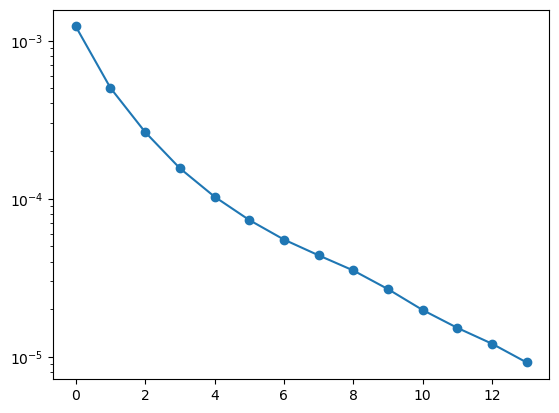

In [65]:
plt.semilogy(solver.power_res, '-o')

In [54]:
solver.phi_norms()

(0.008904956061735195, 0.0023207973276131153)

In [57]:
solver.phi1

In [67]:
1/1.005466

0.9945637147352571

In [26]:
solver.export(name ='test_iaea20_powermet')

Archivos guardados en:  outputs/test_iaea20_powermet


In [66]:
from mpi4py import MPI
from dolfinx import *
from dolfinx import fem, default_scalar_type
import numpy as np
from slepc4py import SLEPc
from mshr import *
import ufl
import os
import basix
import gmsh
from dolfinx.io import gmshio
import dolfinx.fem.petsc as fem_petsc


class NeutronTransportSolver2:
    def __init__(
            self,
            domain,
            
            D1M=2.0, D2M=0.3,
            Sa1M=1e-8, Sa2M=0.01,
            nusigf1M=1e-8, nusigf2M=1e-8,
            S12M=0.04,

            D1F=5.0, D2F=0.4,
            Sa1F=0.01, Sa2F=0.08,
            nusigf1F=0.135, nusigf2F=0.135,
            S12F=0.02,

            D13=10.0, D23=0.4,
            Sa13=0.01, Sa23=0.085,
            nusigf13=0.135, nusigf23=0.135,
            S123=0.02,

            D14=15.0, D24=0.4,
            Sa14=0.01, Sa24=0.13,
            nusigf14=0.135, nusigf24=0.135,
            S124=0.02,
            N_eig=4,
            k=1,
            bord_cond='dir',
            cell_tags=None,
            facet_tags=None,
            ids=None
    ):
        self.domain = domain
        self.cell_tags = cell_tags

        self.D1M, self.D2M = D1M, D2M
        self.Sa1M, self.Sa2M = Sa1M, Sa2M
        self.nusigf1M, self.nusigf2M = nusigf1M, nusigf2M
        self.S12M = S12M
        self.D1F, self.D2F = D1F, D2F
        self.Sa1F, self.Sa2F = Sa1F, Sa2F
        self.nusigf1F, self.nusigf2F = nusigf1F, nusigf2F
        self.S12F = S12F

        self.D13, self.D23 = D13, D23
        self.Sa13, self.Sa23 = Sa13, Sa23
        self.nusigf13, self.nusigf23 = nusigf13, nusigf23
        self.S123 = S123
        self.D14, self.D24 = D14, D24
        self.Sa14, self.Sa24 = Sa14, Sa24
        self.nusigf14, self.nusigf24 = nusigf14, nusigf24
        self.S124 = S124

        self.N_eig = N_eig
        self.k = k
        self.bord_cond = bord_cond
        self.facet_tags = facet_tags
        self.V = self._function_space()
        self.eigvals = None
        self.vr = None
        self.vi = None
        self.phi1 = None
        self.phi2 = None
        self.phi1_list = None
        self.phi2_list = None
        if ids is None:
            self.MOD, self.FUEL, self.G_HEX, self.G_IFACE = 1, 2, 11, 12
        else:
            self.MOD, self.FUEL, self.G_HEX, self.G_IFACE = ids


    def _function_space(self):
        H = basix.ufl.element("Lagrange", self.domain.basix_cell(), self.k)
        Vm = basix.ufl.mixed_element([H, H])
        V = fem.functionspace(self.domain, Vm)
        return V


    def solve(self):
        phi1, phi2 = ufl.TrialFunctions(self.V)
        v1, v2 = ufl.TestFunctions(self.V)

        # dx = ufl.dx
        dx = ufl.Measure("dx", domain=self.domain,
                         subdomain_data=self.cell_tags)
        ds = ufl.Measure("ds", domain=self.domain,
                         subdomain_data=self.facet_tags)
                         
        available_tags = np.unique(self.cell_tags.values)

        
        if 1 in available_tags:
            A = self.D1M*ufl.inner(ufl.grad(phi1), ufl.grad(v1))*dx(1)
            A += self.D1M*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(1)
            A += (self.Sa1M + self.S12M)*phi1*v1*dx(1)
            A += self.D2M*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(1)
            A += self.Sa2M*phi2*v2*dx(1)
            A -= self.S12M*phi1*v2*dx(1)
            F = (self.nusigf1M*phi1*v1 + self.nusigf2M*phi2*v1)*dx(1)
        if 2 in available_tags:
            A += self.D1F*ufl.inner(ufl.grad(phi1), ufl.grad(v1))*dx(2)
            A += self.D1F*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(2)
            A += (self.Sa1F + self.S12F)*phi1*v1*dx(2)
            A += self.D2F*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(2)
            A += self.Sa2F*phi2*v2*dx(2)
            A -= self.S12F*phi1*v2*dx(2)
            F += (self.nusigf1F*phi1*v1 + self.nusigf2F*phi2*v1)*dx(2)
        if 3 in available_tags:
            A += self.D13*ufl.inner(ufl.grad(phi1), ufl.grad(v1))*dx(3)
            A += self.D13*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(3)
            A += (self.Sa13 + self.S123)*phi1*v1*dx(3)
            A += self.D23*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(3)
            A += self.Sa23*phi2*v2*dx(3)
            A -= self.S123*phi1*v2*dx(3)
            F += (self.nusigf13*phi1*v1 + self.nusigf23*phi2*v1)*dx(3)
        if 4 in available_tags:
            A += self.D14*ufl.inner(ufl.grad(phi1), ufl.grad(v1))*dx(4)
            A += self.D14*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(4)
            A += (self.Sa14 + self.S124)*phi1*v1*dx(4)
            A += self.D24*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(4)
            A += self.Sa24*phi2*v2*dx(4)
            A -= self.S124*phi1*v2*dx(4)
            F += (self.nusigf14*phi1*v1 + self.nusigf24*phi2*v1)*dx(4)
        if 5 in available_tags:
            A += self.D14*ufl.inner(ufl.grad(phi1), ufl.grad(v1))*dx(5)
            A += self.D14*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(5)
            A += (self.Sa14 + self.S124)*phi1*v1*dx(5)
            A += self.D24*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(5)
            A += self.Sa24*phi2*v2*dx(5)
            A -= self.S124*phi1*v2*dx(5)
            F += (self.nusigf14*phi1*v1 + self.nusigf24*phi2*v1)*dx(5)
        if 6 in available_tags:
            A += self.D14*ufl.inner(ufl.grad(phi1), ufl.grad(v1))*dx(6)
            A += self.D14*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(6)
            A += (self.Sa14 + self.S124)*phi1*v1*dx(6)
            A += self.D24*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(6)
            A += self.Sa24*phi2*v2*dx(6)
            A -= self.S124*phi1*v2*dx(6)
            F += (self.nusigf14*phi1*v1 + self.nusigf24*phi2*v1)*dx(6)
        if 7 in available_tags:
            A += self.D14*ufl.inner(ufl.grad(phi1), ufl.grad(v1))*dx(7)
            A += self.D14*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(7)
            A += (self.Sa14 + self.S124)*phi1*v1*dx(7)
            A += self.D24*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(7)
            A += self.Sa24*phi2*v2*dx(7)
            A -= self.S124*phi1*v2*dx(7)
            F += (self.nusigf14*phi1*v1 + self.nusigf24*phi2*v1)*dx(7)
        if 8 in available_tags:
            A += self.D14*ufl.inner(ufl.grad(phi1), ufl.grad(v1))*dx(8)
            A += self.D14*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(8)
            A += (self.Sa14 + self.S124)*phi1*v1*dx(8)
            A += self.D24*ufl.inner(ufl.grad(phi2), ufl.grad(v2))*dx(8)
            A += self.Sa24*phi2*v2*dx(8)
            A -= self.S124*phi1*v2*dx(8)
            F += (self.nusigf14*phi1*v1 + self.nusigf24*phi2*v1)*dx(8)

        def boundary_all(x):
            return np.full(x.shape[1], True, dtype=bool)

        if self.bord_cond == 'dir':
            if self.facet_tags is None:
                boundary_facets = mesh.locate_entities_boundary(
                    self.domain, self.domain.topology.dim-1,
                    lambda x: np.full(x.shape[1], True, dtype=bool))
            else:
                boundary_facets = self.facet_tags.find(self.G_HEX)

            dofs1 = fem.locate_dofs_topological(self.V.sub(
                0), self.domain.topology.dim-1, boundary_facets)
            dofs2 = fem.locate_dofs_topological(self.V.sub(
                1), self.domain.topology.dim-1, boundary_facets)

            zero = default_scalar_type(0)
            bc1 = fem.dirichletbc(zero, dofs1, self.V.sub(0))
            bc2 = fem.dirichletbc(zero, dofs2, self.V.sub(1))
            bcs = [bc1, bc2]

        elif self.bord_cond == 'neu':
            bcs = []
        elif self.bord_cond == 'rob':
            ds = ufl.Measure("ds", domain=self.domain, subdomain_data=self.facet_tags) \
                if self.facet_tags is not None else ufl.ds
            cst_rob = 0.4692
            alfa1 = cst_rob/self.D1M
            alfa2 = cst_rob/self.D2M
            alfa21 = cst_rob/self.D1F
            alfa22 = cst_rob/self.D2F
            
            A += alfa1 * phi1 * v1 * ds(11) + alfa2 * phi2 * v2 * ds(11)
            #A += alfa1 * phi1 * v1 * ds(12) + alfa2 * phi2 * v2 * ds(12)
            #A += alfa1 * phi1 * v1 * ds(13) + alfa2 * phi2 * v2 * ds(13)
            #A += alfa1 * phi1 * v1 * ds(14) + alfa2 * phi2 * v2 * ds(14)
            #A += alfa1 * phi1 * v1 * ds(15) + alfa2 * phi2 * v2 * ds(15)
            #A += alfa1 * phi1 * v1 * ds(16) + alfa2 * phi2 * v2 * ds(16)
            #A += alfa1 * phi1 * v1 * ds(17) + alfa2 * phi2 * v2 * ds(17)
            bcs = []

        elif self.bord_cond == 'mixed':
            cst_rob = 0.4692
            alfa1 = -cst_rob/self.D1
            alfa2 = -cst_rob/self.D2
            ds = ufl.Measure("ds", domain=self.domain,
                             subdomain_data=self.facet_tags)
            A += alfa1 * phi1 * v1 * ds(1) + alfa2 * phi2 * v2 * ds(1)
            A += alfa1 * phi1 * v1 * ds(2) + alfa2 * phi2 * v2 * ds(2)
            A += alfa1 * phi1 * v1 * ds(7) + alfa2 * phi2 * v2 * ds(7)
            A += alfa1 * phi1 * v1 * ds(8) + alfa2 * phi2 * v2 * ds(8)
            A += alfa1 * phi1 * v1 * ds(9) + alfa2 * phi2 * v2 * ds(9)
            A += alfa1 * phi1 * v1 * ds(10) + alfa2 * phi2 * v2 * ds(10)
            A += alfa1 * phi1 * v1 * ds(11) + alfa2 * phi2 * v2 * ds(11)
            A += alfa1 * phi1 * v1 * ds(13) + alfa2 * phi2 * v2 * ds(13)
            bcs = []
        else:
            raise ValueError(
                "Condición de borde inexistente: debe ser 'dir', 'neu' o 'rob' ")

        # ensamble del sistema
        a = fem_petsc.assemble_matrix(fem.form(A), bcs=bcs, diagonal=1e2)
        a.assemble()
        f = fem_petsc.assemble_matrix(fem.form(F), bcs=bcs, diagonal=1e-2)
        f.assemble()

        # cálculo de vvalores y vectores propios
        eigensolver = SLEPc.EPS().create(MPI.COMM_WORLD)
        eigensolver.setDimensions(self.N_eig)
        eigensolver.setProblemType(SLEPc.EPS.ProblemType.GNHEP)

        st = SLEPc.ST().create(MPI.COMM_WORLD)
        st.setType(SLEPc.ST.Type.SINVERT)
        st.setShift(1.0)
        st.setFromOptions()
        eigensolver.setST(st)
        eigensolver.setOperators(a, f)
        eigensolver.setFromOptions()

        eigensolver.solve()

        self.vr, self.vi = a.getVecs()
        # self.eigvals = [eigensolver.getEigenpair(i, self.vr, self.vi) for i in range(self.N_eig)]
        self.eigvals = []
        self.phi1_list = []
        self.phi2_list = []
        for i in range(self.N_eig):
            lam = eigensolver.getEigenpair(i, self.vr, self.vi)
            self.eigvals.append(lam)

            phi = fem.Function(self.V)
            phi.x.array[:] = self.vr.array

            phi1, phi2 = phi.split()
            V0 = fem.functionspace(self.domain, ("CG", 1))

            phi1_proj = fem.Function(V0)
            phi1_proj.interpolate(fem.Expression(
                phi1, V0.element.interpolation_points()))
            self.phi1_list.append(phi1_proj)

            phi2_proj = fem.Function(V0)
            phi2_proj.interpolate(fem.Expression(
                phi2, V0.element.interpolation_points()))
            self.phi2_list.append(phi2_proj)

    def phi_norms(self, num=0):
        phi2_norm = np.sqrt(fem.assemble_scalar(
            fem.form(ufl.inner(self.phi2_list[num], self.phi2_list[num]) * ufl.dx)))
        phi1_norm = np.sqrt(fem.assemble_scalar(
            fem.form(ufl.inner(self.phi1_list[num], self.phi1_list[num]) * ufl.dx)))
        return phi1_norm, phi2_norm

    def export(self, modo=1, name='result'):
        if not (0 <= modo <= len(self.phi1_list)-1):
            raise ValueError(
                f"Índice de modo inválido: {modo}. Debe estar entre 1 y {len(self.phi1_list)}")

        phi1 = self.phi1_list[modo]
        phi2 = self.phi2_list[modo]
        V0 = fem.functionspace(self.domain, ("CG", 1))
        phi1_proj = fem.Function(V0)
        phi2_proj = fem.Function(V0)

        phi1_proj.interpolate(fem.Expression(
            phi1, V0.element.interpolation_points()))
        phi2_proj.interpolate(fem.Expression(
            phi2, V0.element.interpolation_points()))

        path = f"outputs/{name}"
        if MPI.COMM_WORLD.rank == 0 and not os.path.exists(path):
            os.makedirs(path)

        with io.VTKFile(MPI.COMM_WORLD, f"{path}/phi1_proj.pvd", "w") as vtk:
            vtk.write_function(phi1_proj)

        with io.VTKFile(MPI.COMM_WORLD, f"{path}/phi2_proj.pvd", "w") as vtk:
            vtk.write_function(phi2_proj)

        MPI.COMM_WORLD.Barrier()
        if MPI.COMM_WORLD.rank == 0:
            print("Archivos guardados en: ", path)



In [ ]:
solver = NeutronTransportSolver2(
    domain=domain,
    D1M=2.0/100, D2M=0.3/100,
    Sa1M=1e-8, Sa2M=0.01*100,
    nusigf1M=1e-8, nusigf2M=1e-8,
    S12M=0.04*100,

    D1F=1.5/100, D2F=0.4/100,
    Sa1F=0.01*100, Sa2F=0.08*100,
    nusigf1F=1e-8, nusigf2F=0.135*100,
    S12F=0.02*100,

    D13=1.5/100, D23=0.4/100,
    Sa13=0.01*100, Sa23=0.085*100,
    nusigf13=1e-8, nusigf23=0.135*100,
    S123=0.02*100,

    D14=1.5/100, D24=0.4/100,
    Sa14=0.01*100, Sa24=0.13*100,
    nusigf14=1e-8, nusigf24=0.135*100,
    S124=0.02*100,
    cell_tags=cell_tags,
    facet_tags=facet_tags,                # importante!
    bord_cond="rob",         # o "rob" / "neu"
    N_eig=4,
    k=1
)